In [12]:
###now try to use keras to train the model
###try deep learning 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import random
import nltk.classify.util
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import movie_reviews
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.probability import FreqDist
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer 
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from nltk.stem import WordNetLemmatizer 
from nltk.stem import PorterStemmer
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import PredefinedSplit
from sklearn.pipeline import FeatureUnion
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.svm import SVC
import tensorflow as tf
import keras
import pickle
import sklearn
import sys
import datetime
%matplotlib inline
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
import gensim 
from nltk.stem.snowball import SnowballStemmer
import statistics
from gensim.models import Word2Vec
from nltk.tokenize import RegexpTokenizer
print("sklearn version:",sklearn.__version__)
print("keras version:",keras.__version__)
print("tensorflow version:",tf.__version__)
print("pandas version:",pd.__version__)
print("numpy version:",np.__version__)
print("python version:",sys.version)

sklearn version: 0.20.2
keras version: 2.2.4
tensorflow version: 1.12.0
pandas version: 0.23.4
numpy version: 1.15.4
python version: 3.6.7 |Anaconda custom (64-bit)| (default, Oct 23 2018, 14:01:38) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


In [104]:
tokenizer = RegexpTokenizer(r'\w{3,}')
def simple_cleaning(test_str):
    test_str = re.sub(r"\n", " ", test_str, 0, re.MULTILINE)
    test_str = re.sub(r"(\$+)(?:(?!\1)[\s\S])*\1", "", test_str, 0, re.MULTILINE)
    test_str = re.sub(r"-", " ", test_str, 0, re.MULTILINE)
    test_str = re.sub(r"[\\'/{}\":\(\).,]", "", test_str, 0, re.MULTILINE)
    test_str = test_str.lower()
    return test_str.lower()


In [80]:
df=pd.read_csv("complete_math_arxiv.csv")

/Users/ben/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [105]:
df['simple_abstract']=df['abstract'].apply(lambda x:simple_cleaning(x))

## let we prepare the list of sent, each sent is a list of words
## we will just skip stopwords and any words less than length 3
###  use snowballstemmer to further clean the tokens

In [226]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")
tokenizer_regex = RegexpTokenizer(r'\w{3,}')
df['list_simple_abstract']=df['simple_abstract'].apply(lambda x: tokenizer_regex.tokenize(x))
from nltk.corpus import stopwords
STOPS=set(stopwords.words('english'))
df['list_simple_abstract'] = df['list_simple_abstract'].apply(lambda x : [stemmer.stem(y.strip()) for y in x if y not in STOPS])
df['list_simple_abstract'] = df['list_simple_abstract'].apply(lambda x : [stemmer.stem(y.strip()) for y in x if (y not in STOPS) and (len(re.compile(r'\d').findall(y))==0)])

In [247]:
df['simple_abstract']=df['list_simple_abstract'].apply(lambda x :" ".join(x))

In [139]:
#####Preprocess
def list_of_authors(text):
    names=[]
    name_list=text.split(',')
    for name in name_list:
        name=name.strip()
        if name[0]=='[':
            name=name[1:]
        if name[-1]==']':
            name=name[:-1]
        name=name[1:-1]
        names+=[name]
    return names    


def list_of_categories(text):
    pat=re.compile(r'math.[A-Z][A-Z]')
    return pat.findall(text)

df['categories']=df['categories'].apply(lambda x: list_of_categories(x))
df['authors']=df['authors'].apply(lambda x: list_of_authors(x))
df['created']=df['created'].apply(lambda x:datetime.datetime.strptime(x, "%Y-%m-%d"))
if "clean_abstract" not in df.columns:
    df['clean_abstract']=df['abstract'].apply(lambda x: clean.transform(x))
      
all_cat={}
for i in df.index:
    paper_cats=df.loc[i,"categories"]
    for cat in paper_cats:
        if cat in all_cat:
            all_cat[cat]+=1
        else:
            all_cat[cat]=1

list_of_all_cat=sorted(list(all_cat.items()),key=lambda x: x[1], reverse=True)            
all_cats=list(zip(*list_of_all_cat))[0]
index_to_cat={}
for i in range(len(all_cats)):
    index_to_cat[i]=all_cats[i]    

for i in range(len(index_to_cat)):
    df[index_to_cat[i]]=df["categories"].apply(lambda x: 1 if index_to_cat[i] in x else 0)

      
###make 

df=df[df['clean_abstract'].apply(lambda x : type(x)!=type(3.0))]
df=df[df['categories'].apply(lambda x : len(x)>0)]    
df=df.reset_index().drop(columns=['index'])

In [235]:
train=df[df['created']<=datetime.datetime(year=2017,month=1,day=1)]
valid=df[(df['created']<datetime.datetime(year=2018,month=1,day=1))&(df['created']>datetime.datetime(year=2017,month=1,day=1))]
test=df[df['created']>=datetime.datetime(year=2018,month=1,day=1)]

# FastText
### Now we can try FastText
### One cool thing about FastText is that it doesn't require us to see the wrod before.
### Now we can directly process each input text as a matrix of the form (max_len,max_features), where max_len is the padded sequence length and max_features is the dim of embedding matrix of fasttext

In [227]:
from gensim.models import FastText
max_feature=100
model_ted = FastText(list(df['list_simple_abstract']), size=100, window=3, min_count=2, workers=4,sg=1)

In [228]:
model_ted.save("FastText.model")

In [229]:
model_ted = FastText.load("FastText.model")

In [230]:
word_counts = list(model_ted.wv.vocab)

In [239]:
all_words=[]
for i in df.index:
    all_words+=df.loc[i,'list_simple_abstract']
all_words=set(all_words)    

In [242]:
big_embedding=np.zeros(shape=(len(all_words),max_feature))

In [231]:
max_len = 200
def embedding_fasttext(list_words,max_len,max_features):
    mat=np.zeros(shape=(max_len,max_features))
    temp_list_words=[]
    for x in list_words:
        if x.strip() in model_ted.wv:
            temp_list_words+=[x.strip()]
    list_words=temp_list_words
    
    if len(list_words)>=200:
        for i in range(200):
            mat[i,:]=model_ted.wv[list_words[i]]
    else:
        length=len(list_words)
        for i in range(200-length,200):
            mat[i,:]=model_ted.wv[list_words[i-(200-length)]]
    return mat        

In [250]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(list(df['simple_abstract']))

In [266]:
def build_embedding():
    embedding=np.zeros(shape=(len(tokenizer.word_index)+1,100))
    for word,index in tokenizer.word_index.items():
        if word in model_ted.wv:
            embedding[index,]=model_ted.wv[word]
    return embedding

In [267]:
embedding_matrix = build_embedding()

#### now we can train the model

In [271]:
train=df[df['created']<=datetime.datetime(year=2017,month=1,day=1)]
valid=df[(df['created']<datetime.datetime(year=2018,month=1,day=1))&(df['created']>datetime.datetime(year=2017,month=1,day=1))]
test=df[df['created']>=datetime.datetime(year=2018,month=1,day=1)]
print(len(train))
print(len(valid))
print(len(test))
list_tokenized_train = tokenizer.texts_to_sequences(train['simple_abstract'])
list_tokenized_valid = tokenizer.texts_to_sequences(valid['simple_abstract'])
list_tokenized_test = tokenizer.texts_to_sequences(test['simple_abstract'])

314424
37049
36338


In [272]:
embedding_matrix.shape

(134544, 100)

(array([8.56620e+04, 1.58834e+05, 8.64950e+04, 3.77250e+04, 1.49220e+04,
        4.05600e+03, 9.50000e+01, 1.30000e+01, 5.00000e+00, 4.00000e+00]),
 array([  0. ,  30.9,  61.8,  92.7, 123.6, 154.5, 185.4, 216.3, 247.2,
        278.1, 309. ]),
 <a list of 10 Patch objects>)

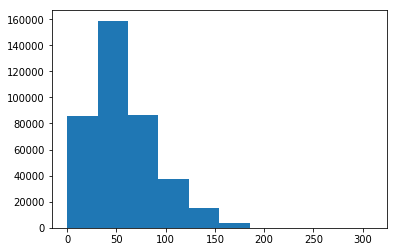

In [274]:
all_lengths=list(df['list_simple_abstract'].apply(lambda x:len(x)))
plt.hist(all_lengths)

## choose the padding length to be 200

In [282]:
maxlen = 200
X_train = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_valid = pad_sequences(list_tokenized_valid, maxlen=maxlen)
X_test = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [305]:
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import Flatten
from keras.layers import BatchNormalization
from keras.layers import SpatialDropout1D
from keras.layers import GRU,GlobalAveragePooling1D,GlobalMaxPooling1D,Conv1D,concatenate
num_class=len(index_to_cat)
inp = Input(shape=(200, ))
###then do embedding
embed_size = 100
max_features = 134544
x = Embedding(max_features, embed_size,weights=[embedding_matrix],trainable=True)(inp)


### then do LSTM
x = Bidirectional(GRU(256,name='LSTM_layer',dropout=0.1, recurrent_dropout=0.1,return_sequences=True))(x)
### 1D conv
x = Conv1D(256, kernel_size = 3, padding = "valid", kernel_initializer = "glorot_uniform")(x)

x = GlobalMaxPooling1D()(x)

### maxpool
#x = GlobalMaxPool1D()(x)
### batchnor
#x = BatchNormalization()(x)
x = Dense(128, activation="relu")(x)

### dropout
x = Dropout(0.1)(x)
### relu
x = Dense(64, activation="relu")(x)
### dropout
x = Dropout(0.1)(x)
###
#x = BatchNormalization()(x)
x = Dense(num_class , activation="sigmoid")(x)

In [306]:
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['categorical_accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 200)               0         
_________________________________________________________________
embedding_11 (Embedding)     (None, 200, 100)          13454400  
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 200, 512)          548352    
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 198, 256)          393472    
_________________________________________________________________
global_max_pooling1d_11 (Glo (None, 256)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_21 (Dropout)         (None, 128)               0         
__________

In [278]:
y_train = train.apply(lambda row:[row[index_to_cat[i]] for i in range(num_class)],axis=1)
y_train = np.array(list(y_train))
y_valid = valid.apply(lambda row:[row[index_to_cat[i]] for i in range(num_class)],axis=1)
y_valid = np.array(list(y_valid))
y_test = test.apply(lambda row:[row[index_to_cat[i]] for i in range(num_class)],axis=1)
y_test = np.array(list(y_test))

In [307]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import os
cwd = os.getcwd()
batch_size = 64
epochs = 10
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
checkpointer = ModelCheckpoint(filepath=cwd+"/fasttext_embedding_max_pool_biGRU.h5", verbose=1, save_best_only=True)
history = model.fit(X_train,y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_valid, y_valid),callbacks=[checkpointer])

Train on 314424 samples, validate on 37049 samples
Epoch 1/10
314424/314424 [==============================] - 11553s 37ms/step - loss: 0.0835 - categorical_accuracy: 0.6088 - val_loss: 0.0621 - val_categorical_accuracy: 0.6938

Epoch 00001: val_loss improved from inf to 0.06207, saving model to /Users/ben/Documents/NLP project/fasttext_embedding_max_pool_biGRU.h5
Epoch 2/10
314424/314424 [==============================] - 9607s 31ms/step - loss: 0.0677 - categorical_accuracy: 0.6709 - val_loss: 0.0593 - val_categorical_accuracy: 0.7012

Epoch 00002: val_loss improved from 0.06207 to 0.05928, saving model to /Users/ben/Documents/NLP project/fasttext_embedding_max_pool_biGRU.h5
Epoch 3/10
314424/314424 [==============================] - 9554s 30ms/step - loss: 0.0627 - categorical_accuracy: 0.6888 - val_loss: 0.0599 - val_categorical_accuracy: 0.6989

Epoch 00003: val_loss did not improve from 0.05928
Epoch 4/10
314424/314424 [==============================] - 9713s 31ms/step - loss: 0.

KeyboardInterrupt: 

In [308]:
_, train_acc = model.evaluate(X_train, y_train, verbose=1)
_, test_acc = model.evaluate(X_valid, y_valid, verbose=1)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

37049/37049 [==============================] - 452s 12ms/step
Train: 0.740, Test: 0.705


NameError: name 'history' is not defined

In [313]:
from keras.models import load_model
model=load_model('fasttext_embedding_max_pool_biGRU.h5')

In [314]:
_, test_acc = model.evaluate(X_test, y_test, verbose=1)
print(test_acc)

36338/36338 [==============================] - 501s 14ms/step
0.703258297092894


In [315]:
y_test_predict=model.predict(X_test)
y_test_predict1=(y_test_predict>0.5).astype(int)
for i in range(len(y_test_predict)):
    best=y_test_predict[i].argmax()
    y_test_predict1[i,best]=1


acc=0
for i in range(len(y_test_predict1)):
    if (y_test_predict1[i]==y_test[i]).all():
        acc+=1
print("AC for testing set:",acc/len(y_test))  

AC for testing set: 0.5814849468875557
